# NHL 2004-2018 Player Data

*Unsupervised Learning*

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import plotly.express as px

Dataset is from Kaggle it's about professional hockey players statistics ommitting goalies from 2004-2018. 

I work for an organization that wants to cluster appropriately the NHL data in order to find the archetypes and then for future predict their positions. My main goal is to see if a model can cluster the data well for future use i.e. NHL management (trading), sports betting (fantasy league) or predicting player positions.

First I will load and read the data, then proceed to reduce dimensionality in order to select the best cluster model that would handle the data well.

In [2]:
#load data
df = pd.read_csv('Downloads/archive (2)/NHL 2004-2018 Player Data.csv', 
                  encoding='ISO-8859-1')

print(df.shape)
df.head()

(13186, 31)


,Rk,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
0,1,Connor McDavid\mcdavco01,20,C,EDM,82,30,70,100,27,...,1733,21.133333,29.0,34,348.0,458.0,43.2,1,1604,2017
1,2,Sidney Crosby\crosbsi01,29,C,PIT,75,44,45,89,17,...,1491,19.883333,27.0,80,842.0,906.0,48.2,0,1104,2017
2,3,Patrick Kane\kanepa01,28,RW,CHI,82,34,55,89,11,...,1754,21.400000,15.0,28,7.0,44.0,13.7,0,206,2017
3,4,Nicklas Backstrom\backsni02,29,C,WSH,82,23,63,86,17,...,1497,18.266667,33.0,45,685.0,648.0,51.4,0,60,2017
4,5,Nikita Kucherov\kucheni01,23,RW,TBL,74,40,45,85,13,...,1438,19.433333,20.0,30,0.0,0.0,0.0,0,119,2017


***Exploratory Data Analysis***

Cleaning the dataset for optimal features

*Exploring dataset variables*

In [3]:
#drop non-essential columns: Rank, Hart (Hart memorial tropy), Votes
df_2 = df.drop(['Rk', 'HART', 'Votes'], axis=1)

In [4]:
#check for nulls
(df_2.isnull().sum() / df_2.isnull().count()).loc[lambda x: x > 0]

#very few

S_percent     0.009404
BLK           0.000076
FOW           0.000076
FOL           0.000076
FO_percent    0.023586
dtype: float64

In [5]:
#drop nulls
df_2.dropna(inplace=True)
df_2.shape

(12768, 28)

In [6]:
#object columns
df_2.select_dtypes(include='O')

,Player,Pos,Tm
0,Connor McDavid\mcdavco01,C,EDM
1,Sidney Crosby\crosbsi01,C,PIT
2,Patrick Kane\kanepa01,RW,CHI
3,Nicklas Backstrom\backsni02,C,WSH
4,Nikita Kucherov\kucheni01,RW,TBL
...,...,...,...
13168,John Quenneville\quennjo02,C,NJD
13173,Kevin Rooney\rooneke01,C,NJD
13174,Nicolas Roy\royni01,C,CAR
13175,Ben Sexton\sextobe01,C,OTT


In [7]:
df_2.Tm.nunique()

35

In [8]:
#pos values
df_2.Pos.value_counts()

#have outliers

D        4215
C        3763
RW       2404
LW       2378
C/LW        3
LW/RW       2
LW/C        1
W           1
RW/LW       1
Name: Pos, dtype: int64

In [9]:
df_2.select_dtypes(include='number')

,Age,GP,G,A,PTS,plusminus,PIM,PS,EV,PP,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
0,20,82,30,70,100,27,26,12.8,26,3,...,251,12.0,1733,21.133333,29.0,34,348.0,458.0,43.2,2017
1,29,75,44,45,89,17,24,12.3,30,14,...,255,17.3,1491,19.883333,27.0,80,842.0,906.0,48.2,2017
2,28,82,34,55,89,11,32,10.8,27,7,...,292,11.6,1754,21.400000,15.0,28,7.0,44.0,13.7,2017
3,29,82,23,63,86,17,38,9.9,15,8,...,162,14.2,1497,18.266667,33.0,45,685.0,648.0,51.4,2017
4,23,74,40,45,85,13,38,12.0,23,17,...,246,16.3,1438,19.433333,20.0,30,0.0,0.0,0.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13168,21,2,0,0,0,-3,0,-0.2,0,0,...,5,0.0,27,13.300000,0.0,4,0.0,1.0,0.0,2018
13173,24,1,0,0,0,0,0,0.0,0,0,...,3,0.0,12,11.800000,0.0,2,1.0,2.0,33.3,2018
13174,20,1,0,0,0,-1,0,-0.1,0,0,...,1,0.0,11,10.800000,0.0,2,6.0,4.0,60.0,2018
13175,26,2,0,0,0,-1,0,-0.1,0,0,...,1,0.0,21,10.300000,0.0,6,3.0,2.0,60.0,2018


In [10]:
#ATOI values
df_2.ATOI.value_counts()

#outliers

18.066667    31
17.000000    31
14.800000    30
16.283333    29
13.800000    29
             ..
4.333333      1
4.233333      1
3.633333      1
3.733333      1
2.400000      1
Name: ATOI, Length: 1381, dtype: int64

In [11]:
#average time on ice
#13-15 min are usually average time for hockey players
df_2[df_2['ATOI'] > 13]

,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,PIM,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
0,Connor McDavid\mcdavco01,20,C,EDM,82,30,70,100,27,26,...,251,12.0,1733,21.133333,29.0,34,348.0,458.0,43.2,2017
1,Sidney Crosby\crosbsi01,29,C,PIT,75,44,45,89,17,24,...,255,17.3,1491,19.883333,27.0,80,842.0,906.0,48.2,2017
2,Patrick Kane\kanepa01,28,RW,CHI,82,34,55,89,11,32,...,292,11.6,1754,21.400000,15.0,28,7.0,44.0,13.7,2017
3,Nicklas Backstrom\backsni02,29,C,WSH,82,23,63,86,17,38,...,162,14.2,1497,18.266667,33.0,45,685.0,648.0,51.4,2017
4,Nikita Kucherov\kucheni01,23,RW,TBL,74,40,45,85,13,38,...,246,16.3,1438,19.433333,20.0,30,0.0,0.0,0.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13026,Peter Cehlarik\cehlape01,22,LW,BOS,6,1,1,2,2,2,...,3,33.3,84,13.900000,3.0,3,2.0,2.0,50.0,2018
13031,Spencer Foo\foosp01,23,RW,CGY,4,2,0,2,1,0,...,16,12.5,63,15.900000,3.0,6,1.0,0.0,100.0,2018
13061,Patrick Eaves\eavespa01,33,RW,ANA,2,1,0,1,0,0,...,3,33.3,33,16.500000,1.0,5,0.0,1.0,0.0,2018
13062,Victor Ejdsell\ejdsevi01,22,C,CHI,6,0,1,1,-1,0,...,7,0.0,80,13.300000,6.0,6,20.0,40.0,33.3,2018


In [12]:
#games played values
df_2.GP.value_counts()

82    1221
81     550
80     427
1      380
79     343
      ... 
21      63
32      60
30      59
83      12
84       7
Name: GP, Length: 84, dtype: int64

In [13]:
#games played higher than 20
df_2[df_2['GP'] > 20]

#more interested in > 20 because means more playing time throughout the season
#it = more statistics

,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,PIM,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
0,Connor McDavid\mcdavco01,20,C,EDM,82,30,70,100,27,26,...,251,12.0,1733,21.133333,29.0,34,348.0,458.0,43.2,2017
1,Sidney Crosby\crosbsi01,29,C,PIT,75,44,45,89,17,24,...,255,17.3,1491,19.883333,27.0,80,842.0,906.0,48.2,2017
2,Patrick Kane\kanepa01,28,RW,CHI,82,34,55,89,11,32,...,292,11.6,1754,21.400000,15.0,28,7.0,44.0,13.7,2017
3,Nicklas Backstrom\backsni02,29,C,WSH,82,23,63,86,17,38,...,162,14.2,1497,18.266667,33.0,45,685.0,648.0,51.4,2017
4,Nikita Kucherov\kucheni01,23,RW,TBL,74,40,45,85,13,38,...,246,16.3,1438,19.433333,20.0,30,0.0,0.0,0.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13017,Alan Quine\quineal01,24,C,NYI,21,0,3,3,-2,4,...,15,0.0,246,11.700000,9.0,32,40.0,63.0,38.8,2018
13028,Jason Dickinson\dickija01,22,C,DAL,27,0,2,2,-2,17,...,16,0.0,230,8.500000,5.0,45,69.0,73.0,48.6,2018
13029,Gabriel Dumont\dumonga01,27,C,TOT,30,1,1,2,1,6,...,38,2.6,271,9.100000,16.0,62,41.0,62.0,39.8,2018
13045,Jordan Schroeder\schrojo01,27,C,CBJ,21,1,1,2,-4,4,...,20,5.0,157,7.500000,2.0,14,39.0,24.0,61.9,2018


In [14]:
#faceoff win percentage
df_2.FO_percent.value_counts()

#421 different values

0.0      7302
50.0      360
100.0     266
33.3      217
40.0      120
         ... 
31.1        1
18.5        1
63.0        1
61.2        1
87.5        1
Name: FO_percent, Length: 421, dtype: int64

In [15]:
#intial value correlations before feature selection
df_2.corr()

,Age,GP,G,A,PTS,plusminus,PIM,PS,EV,PP,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
Age,1.000000,0.261692,0.102707,0.177584,0.155829,0.005478,0.195031,0.140575,0.080665,0.116612,...,0.151764,0.026887,0.251621,0.126853,0.130461,0.071326,0.057956,0.038104,0.023625,-0.065432
GP,0.261692,1.000000,0.624750,0.706952,0.712408,0.080872,0.553933,0.663073,0.630433,0.465044,...,0.784979,0.200641,0.912896,0.449356,0.425259,0.449028,0.275703,0.284902,0.134654,-0.026727
G,0.102707,0.624750,1.000000,0.780896,0.919078,0.223423,0.254867,0.797847,0.961840,0.848563,...,0.887317,0.428246,0.627273,0.385545,0.045743,0.186775,0.337207,0.350927,0.222748,-0.003821
A,0.177584,0.706952,0.780896,1.000000,0.963868,0.273657,0.294350,0.898248,0.726602,0.716635,...,0.849009,0.253408,0.801394,0.455217,0.248642,0.183857,0.337323,0.346914,0.114542,-0.025867
PTS,0.155829,0.712408,0.919078,0.963868,1.000000,0.267917,0.294380,0.906905,0.868553,0.813959,...,0.913995,0.342487,0.773063,0.451591,0.176366,0.195636,0.356603,0.368504,0.167249,-0.017948
plusminus,0.005478,0.080872,0.223423,0.273657,0.267917,1.000000,0.011989,0.452282,0.245738,0.126721,...,0.157798,0.115432,0.140487,0.090132,0.067661,0.005897,0.028415,0.025859,-0.021662,-0.003418
PIM,0.195031,0.553933,0.254867,0.294350,0.294380,0.011989,1.000000,0.283013,0.249984,0.203249,...,0.353133,0.066182,0.447823,0.115994,0.147331,0.358521,0.036441,0.032135,-0.018895,-0.195305
PS,0.140575,0.663073,0.797847,0.898248,0.906905,0.452282,0.283013,1.000000,0.737970,0.744184,...,0.831028,0.272829,0.813320,0.471157,0.344523,0.208906,0.217478,0.224192,0.034361,-0.012088
EV,0.080665,0.630433,0.961840,0.726602,0.868553,0.245738,0.249984,0.737970,1.000000,0.681116,...,0.850841,0.434909,0.596095,0.372349,0.053289,0.228214,0.347411,0.364176,0.264365,0.044351
PP,0.116612,0.465044,0.848563,0.716635,0.813959,0.126721,0.203249,0.744184,0.681116,1.000000,...,0.758688,0.317241,0.539994,0.321221,0.020618,0.066580,0.225448,0.231050,0.093468,-0.083903


*Cleaning dataset*

In [16]:
#drop the position outliers
df_3 = df_2.loc[df_2['Pos'].isin(['D', 'C', 'RW', 'LW'])]

In [17]:
#filtering players who played >20 games and avg time on ice >13
df_4 = df_3.loc[(df_3['GP'] > 20) & (df_3['ATOI'] > 13)].reset_index(drop=True)
df_4

#reasonable number of rows
#new shape of filtered dataset (70007,28)

,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,PIM,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
0,Connor McDavid\mcdavco01,20,C,EDM,82,30,70,100,27,26,...,251,12.0,1733,21.133333,29.0,34,348.0,458.0,43.2,2017
1,Sidney Crosby\crosbsi01,29,C,PIT,75,44,45,89,17,24,...,255,17.3,1491,19.883333,27.0,80,842.0,906.0,48.2,2017
2,Patrick Kane\kanepa01,28,RW,CHI,82,34,55,89,11,32,...,292,11.6,1754,21.400000,15.0,28,7.0,44.0,13.7,2017
3,Nicklas Backstrom\backsni02,29,C,WSH,82,23,63,86,17,38,...,162,14.2,1497,18.266667,33.0,45,685.0,648.0,51.4,2017
4,Nikita Kucherov\kucheni01,23,RW,TBL,74,40,45,85,13,38,...,246,16.3,1438,19.433333,20.0,30,0.0,0.0,0.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7002,Brendan Gaunce\gauncbr01,23,C,VAN,37,4,2,6,0,10,...,55,7.3,492,13.300000,11.0,48,38.0,46.0,45.2,2018
7003,Ben Hutton\huttobe01,24,D,VAN,61,0,6,6,-9,23,...,103,0.0,1123,18.400000,68.0,40,0.0,1.0,0.0,2018
7004,Nikita Scherbak\scherni01,22,RW,MTL,26,4,2,6,-5,8,...,39,10.3,348,13.400000,15.0,18,2.0,0.0,100.0,2018
7005,Colin White\whiteco02,21,C,OTT,21,2,4,6,1,8,...,24,8.3,280,13.400000,15.0,12,20.0,40.0,33.3,2018


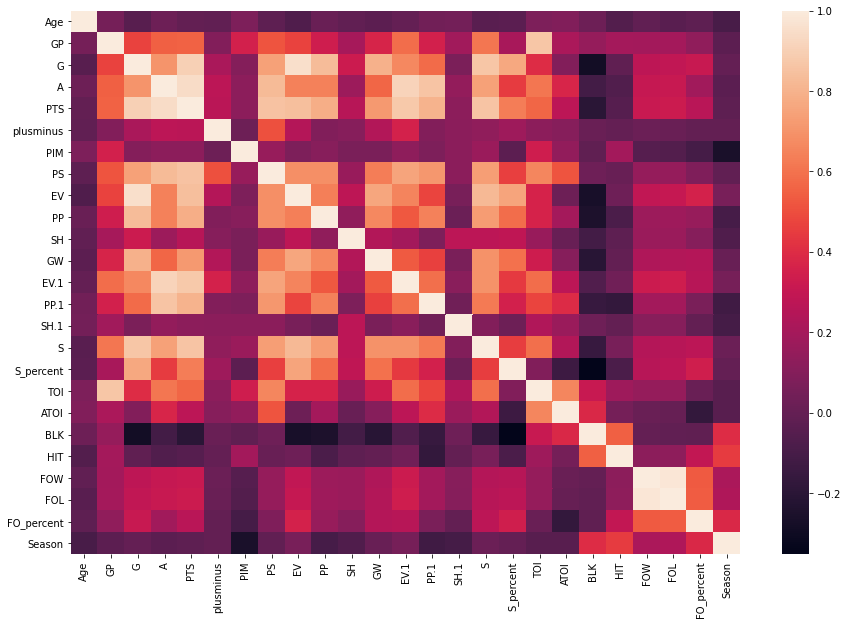

In [18]:
#see heatmap of new correlations after filter
plt.figure(figsize=(15,10))
sns.heatmap(df_4.corr())
plt.show()

In [19]:
#correlations of filtered data
df_4.corr()

,Age,GP,G,A,PTS,plusminus,PIM,PS,EV,PP,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
Age,1.000000,0.050780,-0.042131,0.023955,-0.005169,-0.009725,0.080042,-0.023762,-0.069918,0.016935,...,-0.035349,-0.034900,0.077675,0.090379,0.024478,-0.059047,-0.013461,-0.037133,-0.021912,-0.097593
GP,0.050780,1.000000,0.467759,0.545891,0.554024,0.092801,0.353043,0.516173,0.467141,0.339597,...,0.613456,0.211811,0.867843,0.219489,0.150280,0.200820,0.193887,0.198915,0.134043,-0.029637
G,-0.042131,0.467759,1.000000,0.702519,0.900262,0.213132,0.101695,0.746312,0.952995,0.833049,...,0.865809,0.766222,0.402267,0.095078,-0.285824,-0.015967,0.279075,0.291082,0.312460,-0.002594
A,0.023955,0.545891,0.702519,1.000000,0.942274,0.276126,0.127222,0.826605,0.642811,0.644474,...,0.742538,0.447654,0.609814,0.374666,-0.113922,-0.062990,0.303871,0.311322,0.191644,-0.031380
PTS,-0.005169,0.554024,0.900262,0.942274,1.000000,0.269195,0.125675,0.856807,0.841620,0.786201,...,0.861604,0.634358,0.562313,0.273931,-0.204172,-0.046046,0.317195,0.327402,0.264250,-0.020417
plusminus,-0.009725,0.092801,0.213132,0.276126,0.269195,1.000000,0.024742,0.507131,0.248187,0.089771,...,0.137472,0.178507,0.125623,0.104659,0.016428,0.000133,0.020785,0.017170,-0.006217,-0.007665
PIM,0.080042,0.353043,0.101695,0.127222,0.125675,0.024742,1.000000,0.158115,0.078001,0.111171,...,0.168384,-0.029513,0.338292,0.139445,-0.014526,0.193850,-0.049816,-0.058084,-0.105462,-0.260556
PS,-0.023762,0.516173,0.746312,0.826605,0.856807,0.507131,0.158115,1.000000,0.683677,0.687791,...,0.731667,0.459045,0.661114,0.514216,0.029682,0.009055,0.150643,0.154184,0.084231,-0.009515
EV,-0.069918,0.467141,0.952995,0.642811,0.841620,0.248187,0.078001,0.683677,1.000000,0.638346,...,0.821126,0.754959,0.363999,0.024789,-0.264643,0.028387,0.288954,0.304509,0.356148,0.062897
PP,0.016935,0.339597,0.833049,0.644474,0.786201,0.089771,0.111171,0.687791,0.638346,1.000000,...,0.730497,0.586992,0.362973,0.200711,-0.248290,-0.086932,0.174233,0.177736,0.156087,-0.103052


***Feature Engineering***

Selecting small number of numeric columns out of filtered dataset.

In [20]:
#choosing some offensive and defensive columns for feature engineering
#BLK, HIT, G (Games), A (Assists), PIM (penalty in minutes), FOW (face-off wins),  
hockey = df_4[['Pos', 'G', 'A', 'PIM', 'BLK', 'HIT', 'FOW']]
hockey

,Pos,G,A,PIM,BLK,HIT,FOW
0,C,30,70,26,29.0,34,348.0
1,C,44,45,24,27.0,80,842.0
2,RW,34,55,32,15.0,28,7.0
3,C,23,63,38,33.0,45,685.0
4,RW,40,45,38,20.0,30,0.0
...,...,...,...,...,...,...,...
7002,C,4,2,10,11.0,48,38.0
7003,D,0,6,23,68.0,40,0.0
7004,RW,4,2,8,15.0,18,2.0
7005,C,2,4,8,15.0,12,20.0


In [21]:
#see value distributions of selected columns
hockey.describe()

#different measures in values

,G,A,PIM,BLK,HIT,FOW
count,7007.000000,7007.000000,7007.000000,7007.000000,7007.000000,7007.000000
mean,11.779649,19.821607,40.027544,39.390324,56.906665,92.043956
std,9.864264,12.825110,27.045055,41.882514,56.513172,199.097003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,10.000000,21.000000,0.000000,0.000000,0.000000
50%,10.000000,17.000000,34.000000,28.000000,45.000000,0.000000
75%,18.000000,27.000000,52.000000,56.000000,86.500000,30.000000
max,65.000000,96.000000,257.000000,283.000000,364.000000,1273.000000


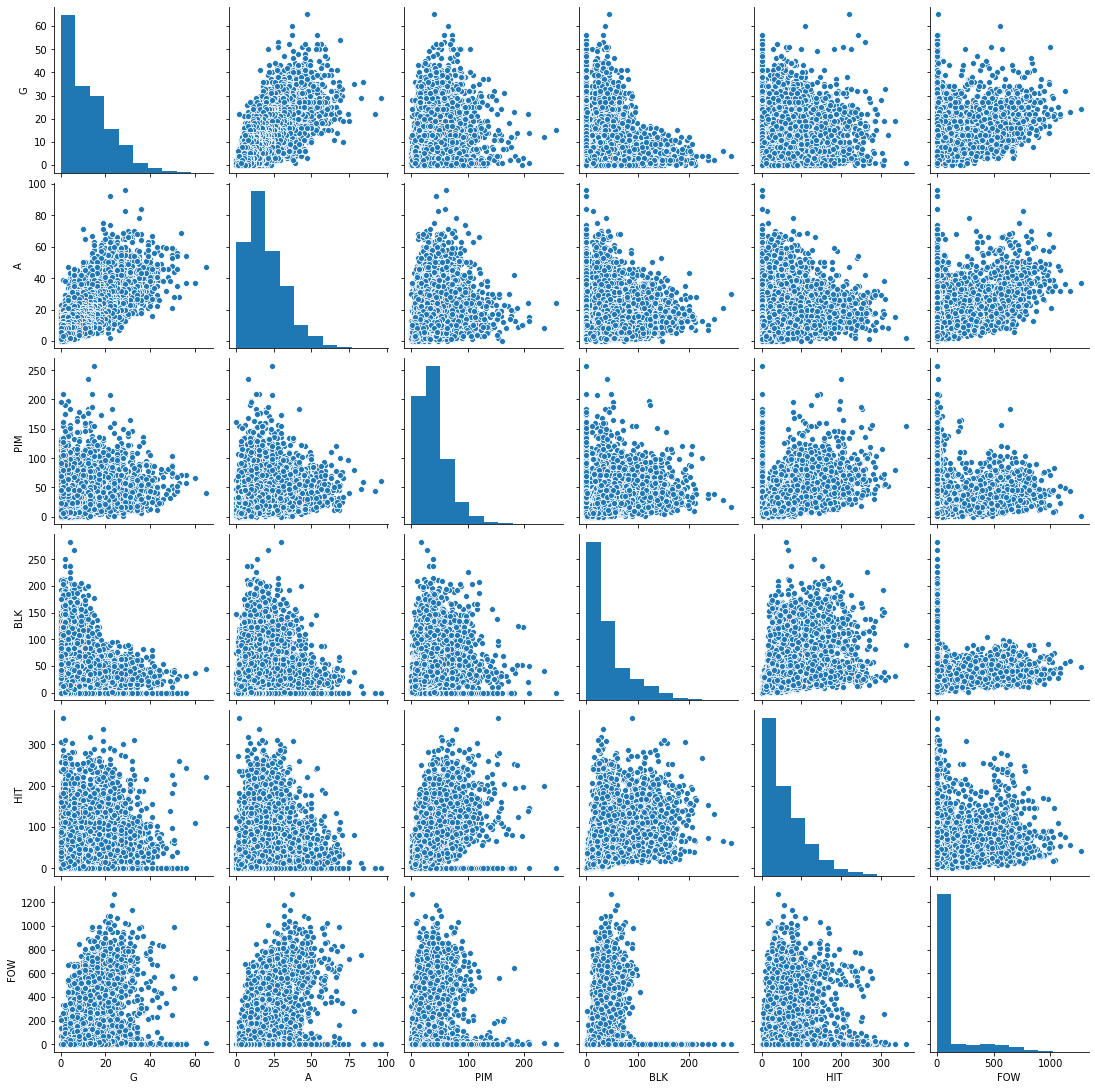

In [22]:
sns.pairplot(hockey)
plt.show()

***Split and Scale data***

Dimensionality reduction techniques are sensitive to the scale of values

In [23]:
#split data for comparison
X = hockey.drop(['Pos'], axis=1)
y = hockey.Pos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(5605, 6)

In [24]:
#scaling -- StandardScaler
scale = StandardScaler()
X_scale = scale.fit_transform(X_train)

In [25]:
#scaled data 
pd.DataFrame(X_scale, columns=X.columns)

,G,A,PIM,BLK,HIT,FOW
0,0.941846,0.490382,-0.882210,-0.603371,0.019819,0.612947
1,-1.089963,-0.996993,-1.252152,0.781888,-0.759726,-0.463445
2,-0.988373,-0.292447,0.782527,2.382101,3.580920,-0.463445
3,0.840256,0.568665,0.745533,-0.651139,0.374157,-0.423393
4,-0.074059,1.116646,-0.882210,0.089258,0.746213,1.303841
...,...,...,...,...,...,...
5600,-0.175649,0.568665,0.301603,-0.937744,-1.007762,-0.463445
5601,-1.191554,-1.075276,-0.438280,2.023844,0.143837,-0.463445
5602,0.535484,-0.135881,1.115475,-0.937744,-1.007762,-0.463445
5603,-0.886782,-0.605579,0.967498,-0.937744,-1.007762,-0.463445


***Dimensionality Reduction***

*Principal Component Analysis*

In [26]:
#pca
#select n_components parameter
#picking random number for n_components
pca = PCA(n_components=5)
pca_scaled = pca.fit_transform(X_scale)

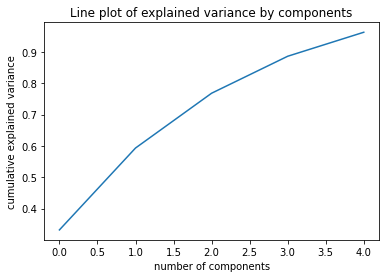

In [27]:
#cummulative plot of explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Line plot of explained variance by components')
plt.show()

In [28]:
#to see the actual variance number for each component
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))

#best n_components=4
#over 85% almost 90%

,0
0,0.332178
1,0.593449
2,0.768320
3,0.886272
4,0.962874


In [29]:
#best n_component pca fitting to train set
pca = PCA(n_components=4)
pca_scaled = pca.fit_transform(X_scale)

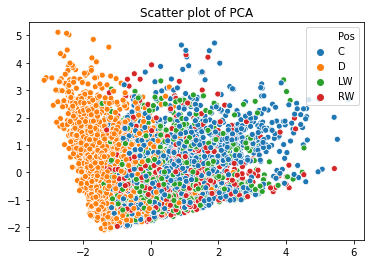

In [30]:
# Plot reduced data in two dimensions using seaborn scatterplot
sns.scatterplot(x=pca_scaled[:,0], y=pca_scaled[:,1], hue=y_train)
plt.title('Scatter plot of PCA')
plt.show()

*t-SNE*

In [31]:
#tsne 
#pick n_components and perplexity
#perplexity = default
tsne = TSNE(n_components=3, perplexity=30, verbose=1)
tsne_scaled = tsne.fit_transform(X_scale)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5605 samples in 0.004s...
[t-SNE] Computed neighbors for 5605 samples in 0.272s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5605
[t-SNE] Computed conditional probabilities for sample 2000 / 5605
[t-SNE] Computed conditional probabilities for sample 3000 / 5605
[t-SNE] Computed conditional probabilities for sample 4000 / 5605
[t-SNE] Computed conditional probabilities for sample 5000 / 5605
[t-SNE] Computed conditional probabilities for sample 5605 / 5605
[t-SNE] Mean sigma: 0.328842
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.230713
[t-SNE] KL divergence after 1000 iterations: 1.127641


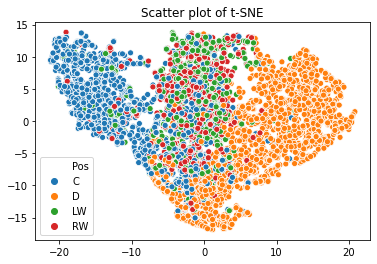

In [32]:
# Plot reduced data in two dimensions using seaborn scatterplot
sns.scatterplot(x=tsne_scaled[:,0], y=tsne_scaled[:,1], hue=y_train)
plt.title('Scatter plot of t-SNE')
plt.show()

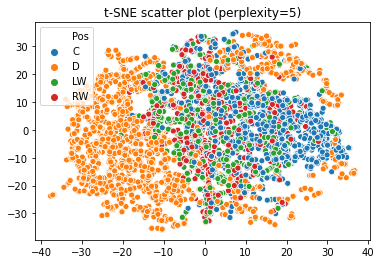

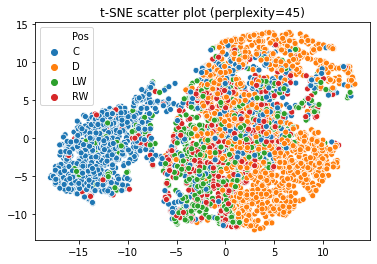

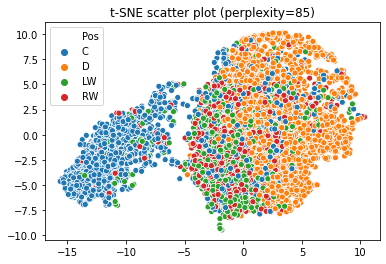

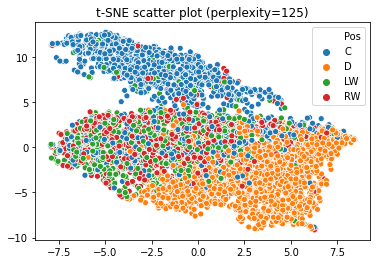

In [33]:
#finding best perplexity 
for i in range(5, 130, 40):
    # Run TSNE for each of these perplexity values and transform X_train_sub
    tsne = TSNE(n_components=3, perplexity=i)
    tsne_components = tsne.fit_transform(X_scale)
    # Plot reduced features in two dimensions using seaborn scatterplot
    sns.scatterplot(x=tsne_components[:,0], y=tsne_components[:,1], hue=y_train)
    plt.title(f't-SNE scatter plot (perplexity={i})')
    plt.show() 

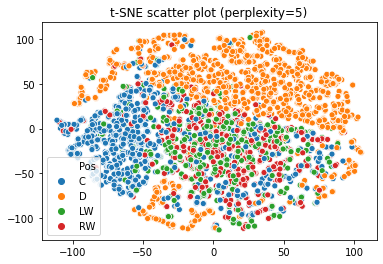

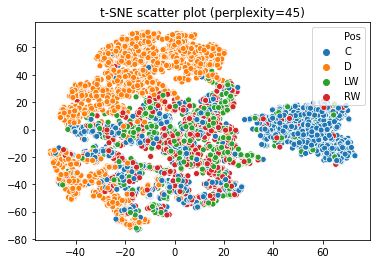

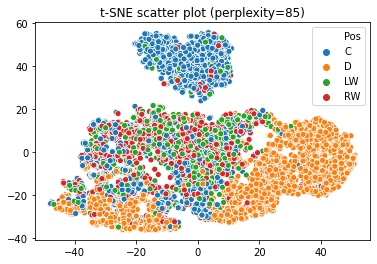

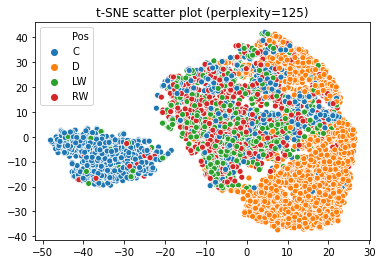

In [34]:
#finding best perplexity 
for i in range(5, 130, 40):
    # Run TSNE for each of these perplexity values and transform X_train_sub
    tsne = TSNE(n_components=2, perplexity=i)
    tsne_components = tsne.fit_transform(X_scale)
    # Plot reduced features in two dimensions using seaborn scatterplot
    sns.scatterplot(x=tsne_components[:,0], y=tsne_components[:,1], hue=y_train)
    plt.title(f't-SNE scatter plot (perplexity={i})')
    plt.show() 

***CLUSTERING ALGORITHMS***

*K-Means*

In [36]:
#trying to find best K for Kmeans through silhouette score
scores = []
K = range(2,11)
goal = 0

for k in K:
    pred = KMeans(n_clusters=k).fit_predict(pca_scaled)
    score = metrics.silhouette_score(pca_scaled, pred, metric='euclidean')
    if score > goal:
        goal = score
        cluster = k
    scores.append(score)

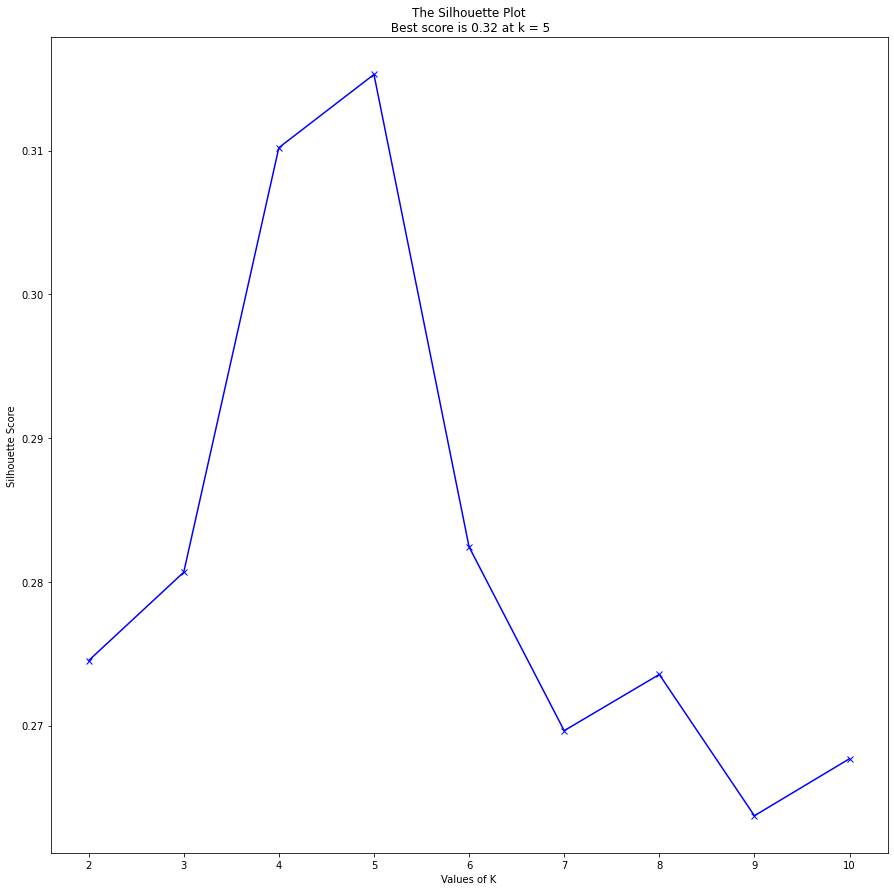

In [37]:
#visual of silhouette score
plt.figure(figsize=(15, 15))
plt.plot(K, scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Plot\n Best score is {:0.2f} at k = {}'.format(goal, cluster)) 
plt.show()

In [38]:
#K-Means
#using silhouette score cluster
kmeans = KMeans(n_clusters=5)
km_cluster = kmeans.fit_predict(pca_scaled)

#inversing scaled features
clusters = kmeans.cluster_centers_
inverse = pd.DataFrame(pca.inverse_transform(clusters), columns=X_train.columns)
inverse.style.background_gradient()

,G,A,PIM,BLK,HIT,FOW
0,-0.049483,-0.195792,2.065381,-0.788803,-0.067892,-0.434814
1,1.164454,1.161376,0.054595,-0.464004,-0.414149,-0.305157
2,-0.557989,-0.605608,-0.479913,-0.331144,-0.574754,-0.283755
3,0.693887,0.670522,-0.163873,-0.088924,0.427706,2.326590
4,-0.521431,-0.370349,0.113609,1.338610,1.145386,-0.426259


In [39]:
#showing clusters for train data
X_train['K_Cluster'] = km_cluster
X_train

<ipython-input-39-72de4692187e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['K_Cluster'] = km_cluster


,G,A,PIM,BLK,HIT,FOW,K_Cluster
3972,21,26,16,14.0,58,215.0,1
913,1,7,6,72.0,14,0.0,2
2737,2,16,61,139.0,259,0.0,4
3486,20,27,60,12.0,78,8.0,1
125,11,34,16,43.0,99,353.0,3
...,...,...,...,...,...,...,...
4989,10,27,48,0.0,0,0.0,2
2366,0,6,28,124.0,65,0.0,4
6349,17,18,70,0.0,0,0.0,0
6102,3,12,66,0.0,0,0.0,2


In [40]:
#cluster counts
X_train.K_Cluster.value_counts()

2    2094
4    1214
1    1142
3     711
0     444
Name: K_Cluster, dtype: int64

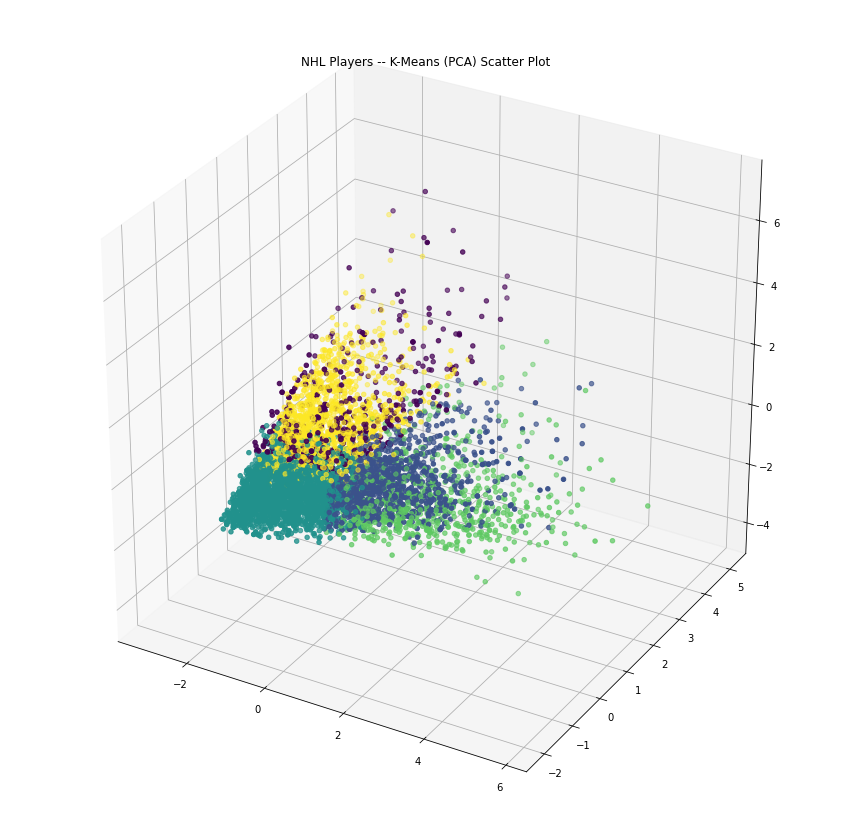

In [41]:
#3D graph to visulaize K-Means 
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")

    
# Creating plot
ax.scatter3D(pca_scaled[:, 0], pca_scaled[:,1], pca_scaled[:,2], c=km_cluster)
plt.title("NHL Players -- K-Means (PCA) Scatter Plot")
 
# show plot
plt.show()

*DBSCAN*

In [42]:
#setting tsne = to the best in my opinion perplexity and components for DBSCAN
tsne = TSNE(n_components=2, perplexity=125, metric='euclidean')
tsne_scaled = tsne.fit_transform(X_scale)

In [46]:
#Silhouette Graph
scores = []

#different values of epsilon.
EPS = [0.1, 0.5, 1, 1.5, 2, 3]
EPS.sort

min_samples = 3
goal = 0

for i in EPS:
    #Building and fitting the model
    pred = DBSCAN(eps=i, min_samples=min_samples).fit_predict(tsne_scaled)
    score = metrics.silhouette_score(tsne_scaled, pred, metric='euclidean')
    #track for the max score
    if score > goal:
        goal = score
        epsilon = i
    scores.append(score)


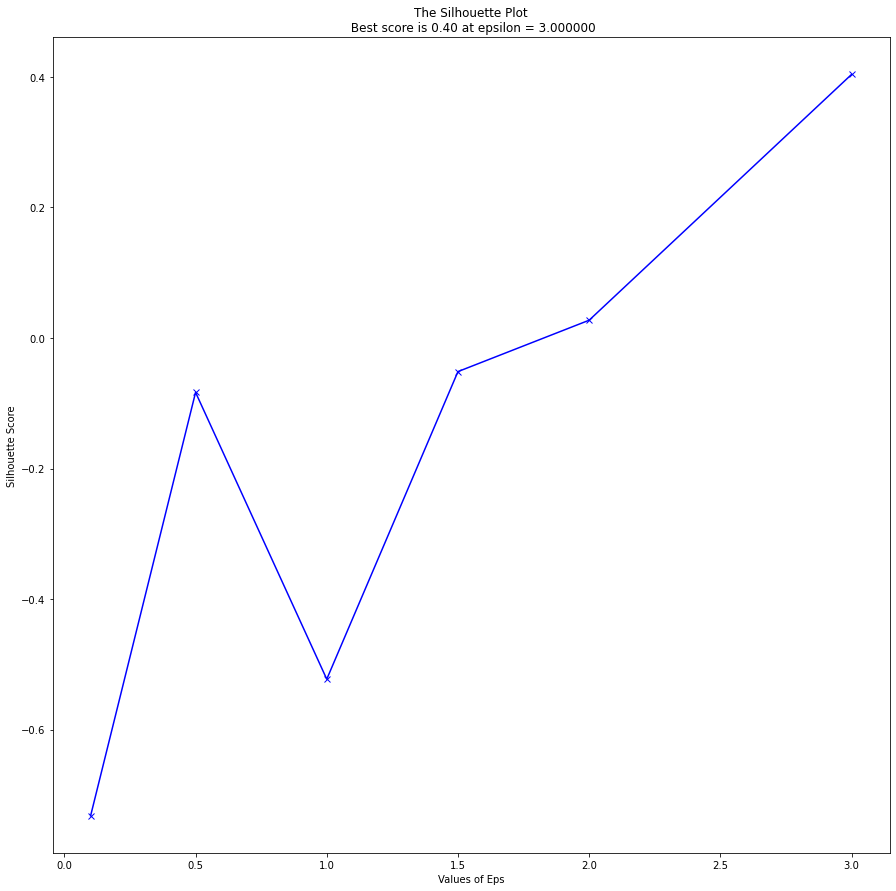

In [44]:
plt.subplots(figsize=(15, 15))
plt.plot(EPS, scores, 'bx-') 
plt.xlabel('Values of Eps') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Plot\n Best score is {:0.02f} at epsilon = {:2f}'.format(goal, epsilon)) 
plt.show()

In [47]:
#fitting the best DBSCAN parameters according to silhouette score
scan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
db_cluster = scan.fit_predict(tsne_scaled)

X_train['db_cluster'] = db_cluster
X_train

<ipython-input-47-09ca3ce8cfa8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['db_cluster'] = db_cluster


,G,A,PIM,BLK,HIT,FOW,K_Cluster,db_cluster
3972,21,26,16,14.0,58,215.0,1,0
913,1,7,6,72.0,14,0.0,2,1
2737,2,16,61,139.0,259,0.0,4,1
3486,20,27,60,12.0,78,8.0,1,1
125,11,34,16,43.0,99,353.0,3,0
...,...,...,...,...,...,...,...,...
4989,10,27,48,0.0,0,0.0,2,1
2366,0,6,28,124.0,65,0.0,4,1
6349,17,18,70,0.0,0,0.0,0,1
6102,3,12,66,0.0,0,0.0,2,1


In [48]:
X_train.db_cluster.value_counts()

1    4655
0     950
Name: db_cluster, dtype: int64

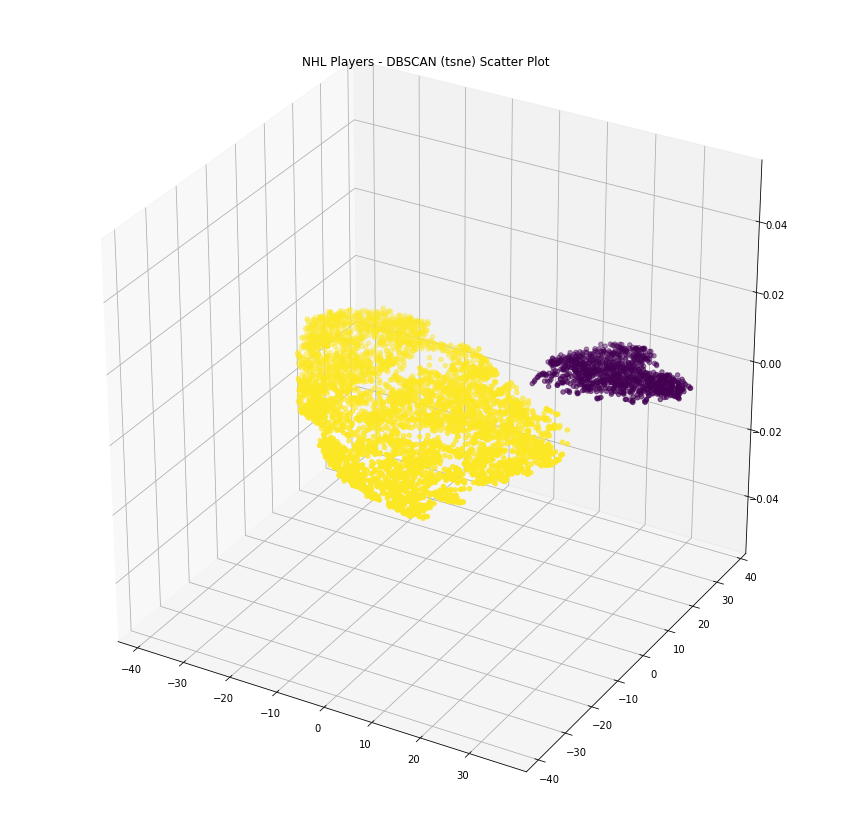

In [49]:
#visual.
# Creating figure
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
    
# Creating plot
ax.scatter3D(tsne_scaled[:, 0], tsne_scaled[:,1], c=db_cluster)
plt.title("NHL Players - DBSCAN (tsne) Scatter Plot")
 
# show plot
plt.show()

*Gaussian Mixture Model (GMM)*

In [50]:
#trying to find best n_components for GaussianMixture through silhouette score
scores = []
G = range(2,11)
goal = 0

for n in G:
    pred = GaussianMixture(n_components=n, covariance_type='full').fit_predict(pca_scaled)
    score = metrics.silhouette_score(pca_scaled, pred, metric='euclidean')
    if score > goal:
        goal = score
        cluster = n
    scores.append(score)

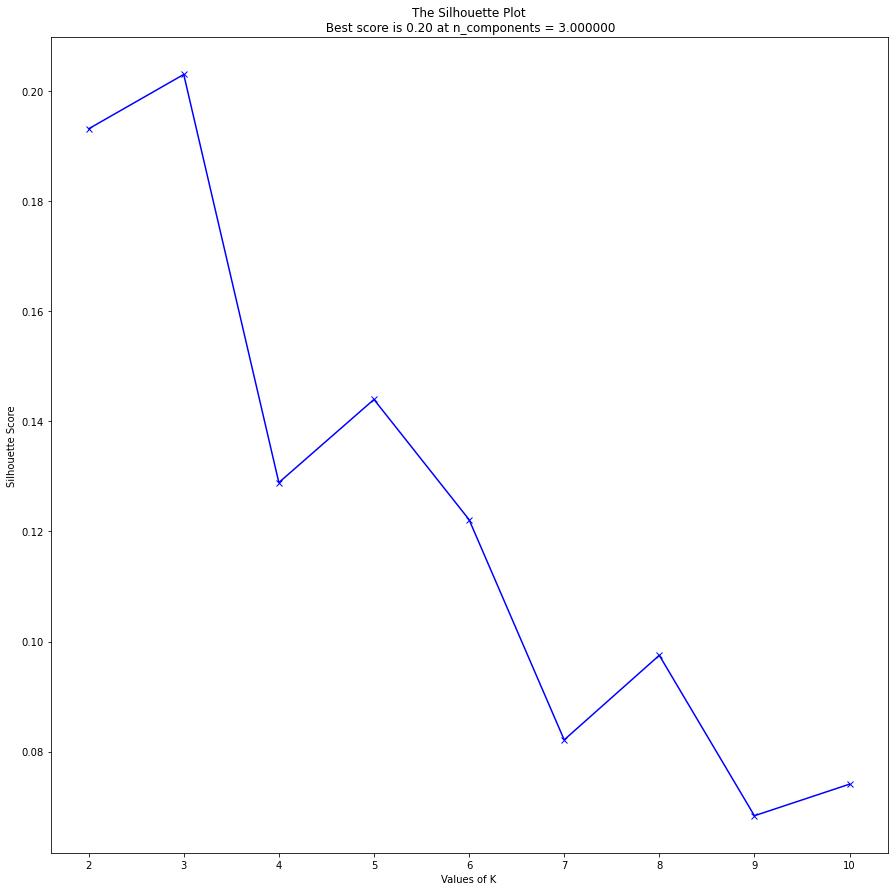

In [51]:
plt.figure(figsize=(15, 15))
plt.plot(G, scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Plot\n Best score is {:0.02f} at n_components = {:2f}'.format(goal, cluster)) 
plt.show()

In [52]:
#gmm
#using the best n_component from silhouette score
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm_cluster = gmm.fit_predict(pca_scaled)

In [53]:
#inversing scaled features
train_columns = X_train[['G', 'A', 'PIM', 'BLK', 'HIT', 'FOW']]

means = gmm.means_
inverse = pd.DataFrame(pca.inverse_transform(means), columns=train_columns.columns)
inverse.style.background_gradient()

,G,A,PIM,BLK,HIT,FOW
0,-0.288296,-0.219455,-0.098828,0.558861,0.363319,-0.428730
1,0.123430,0.001950,0.344065,-1.016105,-0.911476,-0.487093
2,0.448689,0.442039,-0.175768,-0.021315,0.260178,1.399744


In [54]:
#making cluster column
X_train['gmm_cluster'] = gmm_cluster
X_train

<ipython-input-54-e4d15b6f02e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['gmm_cluster'] = gmm_cluster


,G,A,PIM,BLK,HIT,FOW,K_Cluster,db_cluster,gmm_cluster
3972,21,26,16,14.0,58,215.0,1,0,2
913,1,7,6,72.0,14,0.0,2,1,0
2737,2,16,61,139.0,259,0.0,4,1,0
3486,20,27,60,12.0,78,8.0,1,1,0
125,11,34,16,43.0,99,353.0,3,0,2
...,...,...,...,...,...,...,...,...,...
4989,10,27,48,0.0,0,0.0,2,1,1
2366,0,6,28,124.0,65,0.0,4,1,0
6349,17,18,70,0.0,0,0.0,0,1,1
6102,3,12,66,0.0,0,0.0,2,1,1


In [55]:
#gmm cluster counts
X_train.gmm_cluster.value_counts()

0    2865
1    1488
2    1252
Name: gmm_cluster, dtype: int64

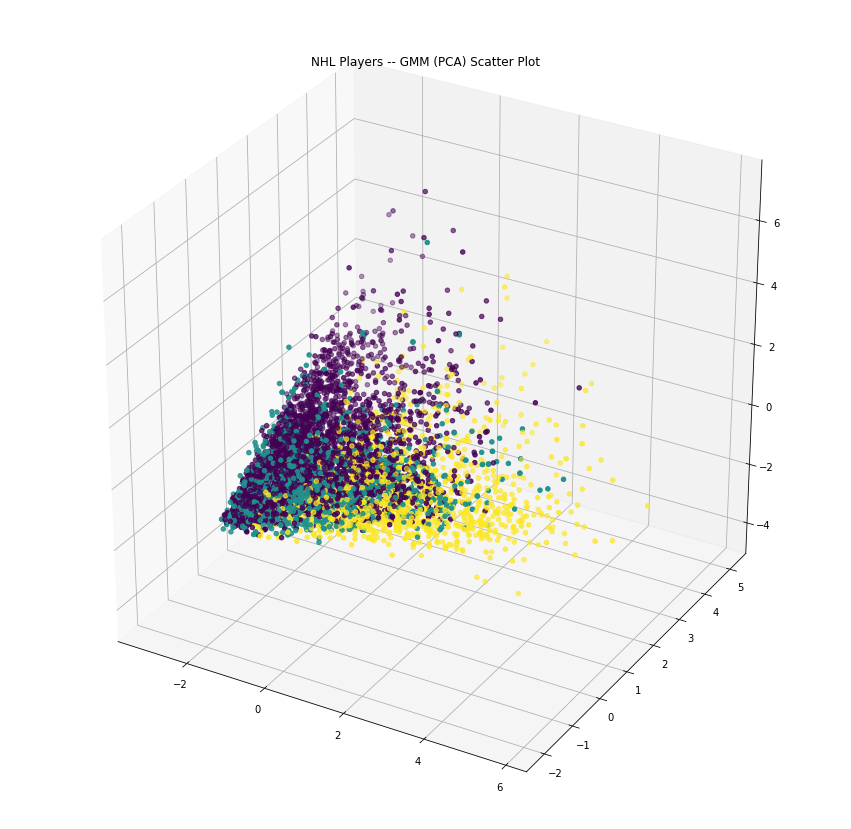

In [56]:
#3D visualization of GMM model
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")

    
# Creating plot
ax.scatter3D(pca_scaled[:, 0], pca_scaled[:,1], pca_scaled[:,2], c=gmm_cluster)
plt.title("NHL Players -- GMM (PCA) Scatter Plot")

# show plot
plt.show()

In [57]:
#trying to find best n_components for GaussianMixture through silhouette score
#using tsne
scores = []
G = range(2,11)
goal = 0

for n in G:
    pred = GaussianMixture(n_components=n, covariance_type='full').fit_predict(tsne_scaled)
    score = metrics.silhouette_score(tsne_scaled, pred, metric='euclidean')
    if score > goal:
        goal = score
        cluster = n
    scores.append(score)

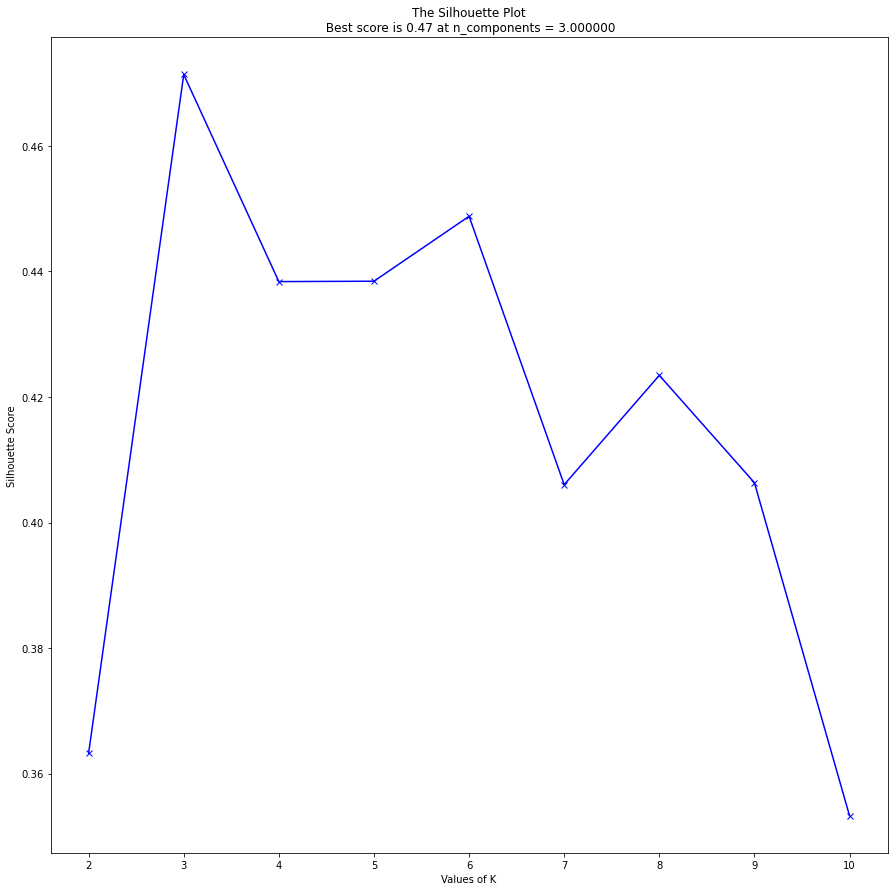

In [58]:
plt.figure(figsize=(15, 15))
plt.plot(G, scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Plot\n Best score is {:0.02f} at n_components = {:2f}'.format(goal, cluster)) 
plt.show()

In [59]:
#GMM
#using tsne best component
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm_cluster = gmm.fit_predict(tsne_scaled)

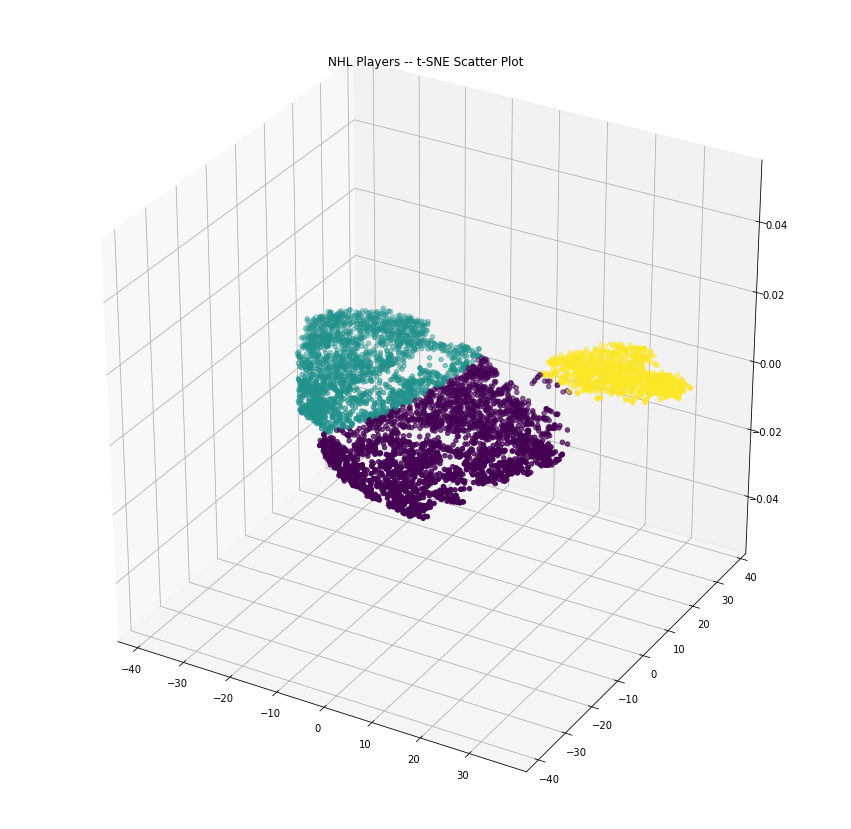

In [60]:
#3D visualization of using GMM model
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")

    
# Creating plot
ax.scatter3D(tsne_scaled[:, 0], tsne_scaled[:,1], c=gmm_cluster)
plt.title("NHL Players -- t-SNE Scatter Plot")
 
# show plot
plt.show()

In [63]:
#making cluster column
X_train['gmm_cluster'] = gmm_cluster


#cluster count values
X_train.gmm_cluster.value_counts()

<ipython-input-63-9f974baa734b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['gmm_cluster'] = gmm_cluster


0    2652
1    2019
2     934
Name: gmm_cluster, dtype: int64

***CONCLUSION***

Based off my analysis above, I believe that DBSCAN and GMM would be the best clustering model for my data on hockey players. The silhouette scores for all 3 models are the following:
* K-Means - 0.32 (k=5, using scaled pca)
* DBSCAN - 0.40 (eps=3, using scaled tsne)
* GMM - 0.20 (n_components=3, using scaled pca); 
    0.47 (n_components=3, using scaled tsne)

Comparing the silhouette scores, the models with the highest scores are DBSCAN and GMM (with tsne). Visually the two models show distinct seperated clusters, although the GMM model looks like there's a slice between the two clusters. If using pca method to reduce dimensionality, K-Means would be the best model for this dataset and features. 

The K-Means model has a higher number of clusters (5) compared to the DBSCAN model which has 2 clusters and the GMM model with 3 clusters. 

The cluster count values are not too extreme for the K-Means (except for 1 cluster which is much lower than the other 4) and the GMM models, but the DBSCAN model's cluster count values are very extreme. There is about a 4000 value count difference between the 2 clusters in the model. 

From my knowledge of the logistics of hockey, the clusters are so different probably because of how it tries to distinguish and cluster between the offensive and defensive features. Since the Left Wing and Right Wing players play both defensive and offensive, this could possibly affect the clustering which is shown through the graph and when I inversed the pca scaled features. The K-Means model does better than the GMM (with pca) at seperating the offensive and defensive variables within the clusters. 

Below I will show how the positions are seperated by the gmm clusters as well as how each feature/metric influences the model's clusters.

In [79]:
X_train = X_train.reset_index(drop=True)
X_train

,G,A,PIM,BLK,HIT,FOW,K_Cluster,db_cluster,gmm_cluster
0,21,26,16,14.0,58,215.0,1,0,2
1,1,7,6,72.0,14,0.0,2,1,1
2,2,16,61,139.0,259,0.0,4,1,1
3,20,27,60,12.0,78,8.0,1,1,0
4,11,34,16,43.0,99,353.0,3,0,2
...,...,...,...,...,...,...,...,...,...
5600,10,27,48,0.0,0,0.0,2,1,0
5601,0,6,28,124.0,65,0.0,4,1,1
5602,17,18,70,0.0,0,0.0,0,1,0
5603,3,12,66,0.0,0,0.0,2,1,0


In [80]:
y_train = y_train.reset_index(drop=True)

In [81]:
train_tot = pd.concat([y_train, X_train], axis=1)
train_tot

,Pos,G,A,PIM,BLK,HIT,FOW,K_Cluster,db_cluster,gmm_cluster
0,C,21,26,16,14.0,58,215.0,1,0,2
1,D,1,7,6,72.0,14,0.0,2,1,1
2,D,2,16,61,139.0,259,0.0,4,1,1
3,LW,20,27,60,12.0,78,8.0,1,1,0
4,C,11,34,16,43.0,99,353.0,3,0,2
...,...,...,...,...,...,...,...,...,...,...
5600,RW,10,27,48,0.0,0,0.0,2,1,0
5601,D,0,6,28,124.0,65,0.0,4,1,1
5602,LW,17,18,70,0.0,0,0.0,0,1,0
5603,D,3,12,66,0.0,0,0.0,2,1,0


In [85]:
#gmm cluster 0 position counts
gmm_0 = train_tot.loc[train_tot['gmm_cluster'] == 0]
gmm_0['Pos'].value_counts()
#all positions are about equal in the counts

RW    725
LW    695
D     626
C     606
Name: Pos, dtype: int64

In [102]:
train_sorted = train_tot.sort_values(by='gmm_cluster', ascending=True)

In [103]:
#first 5 players index in cluster 0 after sort
train_sorted.loc[train_sorted['gmm_cluster'] == 0].head().index

Int64Index([2802, 4221, 2144, 4220, 4218], dtype='int64')

In [104]:
#first 5 players index in cluster 1 after sort
train_sorted.loc[train_sorted['gmm_cluster'] == 1].head().index

Int64Index([5452, 5388, 5474, 3458, 3697], dtype='int64')

In [105]:
#first 5 players index in cluster 2 after sort
train_sorted.loc[train_sorted['gmm_cluster'] == 2].head().index

Int64Index([702, 3086, 5182, 701, 5201], dtype='int64')

In [106]:
#sorting train dataset by gmm_cluster
gmm_sorted = train_tot.sort_values(by='gmm_cluster', ascending=True).index

In [107]:
#hockey dataset sorted by the gmm clusters
df_4.loc[gmm_sorted]

,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,PIM,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
2802,Wojtek Wolski\wolskwo01,25,LW,TOT,31,4,8,12,-5,2,...,50,8.0,427,13.766667,5.0,34,5.0,5.0,50.0,2012
4221,Teddy Purcell\purcete01,23,RW,LAK,40,4,12,16,-4,4,...,68,5.9,541,13.516667,5.0,13,5.0,24.0,17.2,2009
2144,Jakob Silfverberg\silfvja01,22,RW,OTT,48,10,9,19,9,12,...,134,7.5,779,16.233333,13.0,38,5.0,8.0,38.5,2013
4220,Cory Murphy\murphco01,30,D,TOT,32,5,11,16,-4,14,...,55,9.1,575,17.950000,29.0,13,0.0,0.0,0.0,2009
4218,Travis Moen\moentr01,26,LW,TOT,82,7,9,16,-18,91,...,101,6.9,1229,14.983333,42.0,171,4.0,14.0,22.2,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,J.P. Dumont\dumonjp01,30,RW,NSH,82,16,49,65,1,20,...,176,9.1,1435,17.500000,13.0,33,3.0,3.0,50.0,2009
1279,Jay McClement\mccleja01,31,C,CAR,82,7,14,21,-7,17,...,68,10.3,1113,13.583333,53.0,79,549.0,441.0,55.5,2015
1282,Cody Ceci\cecico01,21,D,OTT,81,5,16,21,-4,6,...,130,3.8,1562,19.283333,113.0,89,0.0,0.0,0.0,2015
2677,Willie Mitchell\mitchwi01,34,D,LAK,76,5,19,24,20,44,...,104,4.8,1689,22.233333,136.0,74,0.0,1.0,0.0,2012


In [86]:
#gmm cluster 1 position counts
gmm_1 = train_tot.loc[train_tot['gmm_cluster'] == 1]
gmm_1['Pos'].value_counts()

#Defenders are the dominant of the cluster

D     1587
LW     178
RW     132
C      122
Name: Pos, dtype: int64

In [87]:
#gmm cluster 2 position counts
gmm_2 = train_tot.loc[train_tot['gmm_cluster'] == 2]
gmm_2['Pos'].value_counts()

#Centers are the dominant of the cluster

#because of gmm cluster 0 counts being about equal 
#it shows my validation that LW and RW are harder to seperate in clusters

C     863
LW     41
RW     30
Name: Pos, dtype: int64

In [72]:
fig = px.bar(train_tot, 
            x='gmm_cluster',
            y='Pos',
            title='Avg. Position by Cluster',
            template='none')

fig.update_traces(marker_color='lightskyblue',
                  marker_line_color='black',
                  marker_line_width=1)

fig.show()

In [68]:
#shows how each feature affects the model
#interactive graph with drop down bar
from ipywidgets import interact
@interact(Metric=['G', 'A', 'BLK', 'HIT'])

def barchart(Metric):
    fig = px.bar(train_tot,
            x='K_Cluster',
            y=Metric,
            color='Pos',
            template='none',
            title='Avg. ' + Metric + ' by Cluster')

    fig.update_layout(barmode='group')
    fig.update_traces(marker_line_color='black', marker_line_width=1)

    fig.show()

interactive(children=(Dropdown(description='Metric', options=('G', 'A', 'BLK', 'HIT'), value='G'), Output()), …

In [69]:
#shows how each feature affects the model
#interactive graph with drop down bar
@interact(Metric=['G', 'A', 'BLK', 'HIT'])

def barchart(Metric):
    fig = px.bar(train_tot,
            x='db_cluster',
            y=Metric,
            color='Pos',
            template='none',
            title='Avg. ' + Metric + ' by Cluster')

    fig.update_layout(barmode='group')
    fig.update_traces(marker_line_color='black', marker_line_width=1)

    fig.show()

interactive(children=(Dropdown(description='Metric', options=('G', 'A', 'BLK', 'HIT'), value='G'), Output()), …

In [70]:
#shows how each feature affects the model
#interactive graph with drop down bar
@interact(Metric=['G', 'A', 'BLK', 'HIT'])

def barchart(Metric):
    fig = px.bar(train_tot,
            x='gmm_cluster',
            y=Metric,
            color='Pos',
            template='none',
            title='Avg. ' + Metric + ' by Cluster')

    fig.update_layout(barmode='group')
    fig.update_traces(marker_line_color='black', marker_line_width=1)

    fig.show()

interactive(children=(Dropdown(description='Metric', options=('G', 'A', 'BLK', 'HIT'), value='G'), Output()), …

GMM model assigns probabilities of memberships to each cluster therefore I calculated the entropy (percentage) to show the archetypes of my most confident predicted players and my least confident predicted players and their statistics

In [88]:
#finding entropy through gmm
from scipy.special import entr
pred = pd.DataFrame(gmm_cluster, columns=['pred'])
probs = pd.DataFrame(gmm.predict_proba(tsne_scaled))
entropy = entr(probs)
total = pd.DataFrame(entropy.sum(axis=1), columns=['Total entropy'])

In [89]:
X_en = pd.concat([X_train, pred, probs, total], axis=1)
X_en

,G,A,PIM,BLK,HIT,FOW,K_Cluster,db_cluster,gmm_cluster,pred,0,1,2,Total entropy
0,21,26,16,14.0,58,215.0,1,0,2,2,0.180339,0.000036,8.196247e-01,0.472308
1,1,7,6,72.0,14,0.0,2,1,1,1,0.008223,0.991777,1.347282e-22,0.047666
2,2,16,61,139.0,259,0.0,4,1,1,1,0.000994,0.999006,3.154386e-09,0.007866
3,20,27,60,12.0,78,8.0,1,1,0,0,0.964005,0.035960,3.498202e-05,0.155277
4,11,34,16,43.0,99,353.0,3,0,2,2,0.025900,0.000002,9.740982e-01,0.120211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5600,10,27,48,0.0,0,0.0,2,1,0,0,0.998465,0.001535,1.391510e-25,0.011480
5601,0,6,28,124.0,65,0.0,4,1,1,1,0.000019,0.999981,5.483515e-17,0.000222
5602,17,18,70,0.0,0,0.0,0,1,0,0,0.999212,0.000788,2.554838e-31,0.006419
5603,3,12,66,0.0,0,0.0,2,1,0,0,0.995856,0.004144,1.110810e-37,0.026867


In [90]:
low5 = X_en.sort_values(by='Total entropy', ascending=False).head().index

high5 = X_en.sort_values(by='Total entropy', ascending=True).head().index

In [91]:
print('The 5 predicted labels (players) least confident on:')
hockey.loc[low5]

The 5 predicted labels (players) least confident on:


,Pos,G,A,PIM,BLK,HIT,FOW
5195,C,2,10,28,0.0,0,0.0
4983,LW,23,14,42,0.0,0,0.0
4556,RW,13,18,99,13.0,240,30.0
1125,RW,24,13,28,32.0,155,2.0
68,LW,28,25,58,30.0,132,5.0


In [92]:
print('The 5 predicted labels (players) most confident on:')
hockey.loc[high5]

The 5 predicted labels (players) most confident on:


,Pos,G,A,PIM,BLK,HIT,FOW
1809,C,6,11,41,30.0,225,22.0
4546,LW,11,21,47,23.0,52,193.0
2103,C,13,10,6,24.0,40,32.0
1253,RW,9,14,30,53.0,33,2.0
5530,D,3,23,40,0.0,0,0.0


In [93]:
df_4.loc[high5]

,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,PIM,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
1809,Colin Greening\greenco01,27,C,OTT,76,6,11,17,-15,41,...,108,5.6,1045,13.750000,30.0,225,22.0,37.0,37.3,2014
4546,Vernon Fiddler\fiddlve01,27,LW,NSH,79,11,21,32,-4,47,...,97,11.3,1101,13.933333,23.0,52,193.0,191.0,50.3,2008
2103,Andrew Cogliano\coglian01,25,C,ANA,48,13,10,23,14,6,...,79,16.5,738,15.366667,24.0,40,32.0,60.0,34.8,2013
1253,Erik Condra\condrer01,28,RW,OTT,68,9,14,23,13,30,...,106,8.5,983,14.450000,53.0,33,2.0,7.0,22.2,2015
5530,Ian White\whiteia01,22,D,TOR,76,3,23,26,8,40,...,138,2.2,1408,18.533333,0.0,0,0.0,0.0,0.0,2007


In [94]:
df_4.loc[low5]

,Player,Age,Pos,Tm,GP,G,A,PTS,plusminus,PIM,...,S,S_percent,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,Season
5195,Petr Nedved\nedvepe01,35,C,TOT,40,2,10,12,-25,28,...,39,5.1,592,14.783333,0.0,0,0.0,0.0,0.0,2009
4983,Taylor Pyatt\pyattta01,25,LW,VAN,76,23,14,37,5,42,...,150,15.3,1061,13.966667,0.0,0,0.0,0.0,0.0,2009
4556,David Backes\backeda01,23,RW,STL,72,13,18,31,-11,99,...,129,10.1,1057,14.683333,13.0,240,30.0,37.0,44.8,2008
1125,Nino Niederreiter\niedeni01,22,RW,MIN,80,24,13,37,2,28,...,149,16.1,1164,14.550000,32.0,155,2.0,5.0,28.6,2015
68,Chris Kreider\kreidch01,25,LW,NYR,75,28,25,53,6,58,...,186,15.1,1275,17.000000,30.0,132,5.0,4.0,55.6,2017


Metadata on NHL dataset: (*) don’t need

Rk = Rank *

Player = player name

Age = player’s age

Tm = Team

Pos = player’s position 

GP = games played

G = goals

A = assists

PTS = points

+/- = Plus/Minus 

PIM = penalties in minutes

PS = point shares; estimate of number points contributed by a player

EV = even stregthen goals

PP = power play goals

SH = short-handed goals

GW = game-winning goals

EV = even strength assists

PP = power play assists

SH = short-handed assists

S = shots at goal

S% = shooting percentage

TOI = Time on ice (in minutes)

ATOI = average time on ice

BLK = blocks

HIT = hits

FOW = face-off wins

FOL = face-off loses

FO% = face-off win percentage

HART = receiver of Hart memorial Trophy *

Votes = number of votes for trophy *

Season = player’s season 